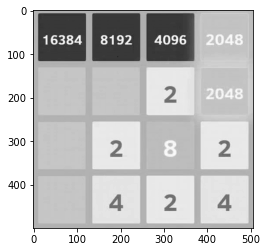

In [64]:
import skimage
import skimage.io
import skimage.color
import skimage.measure
import skimage.feature
import skimage.filters
import skimage.transform
import pytesseract
import imutils
import matplotlib.pyplot as plt
import numpy as np

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
img = skimage.io.imread("2048-3.jpg")
img = skimage.color.rgb2gray(img[:,:,0:3])

plt.rcParams['figure.figsize'] = [4, 4]
plt.imshow(img, cmap="gray", vmin=0, vmax=1.0)


In [45]:
numbers_map = [None]*16
numbers_aspects = [0]*16

for i in range(16):
    number = skimage.io.imread(f"numbers/{i}.png")
    number = number.astype("uint8")
    numbers_map[i] = number
    numbers_aspects[i] = number.shape[0]/number.shape[1]
    

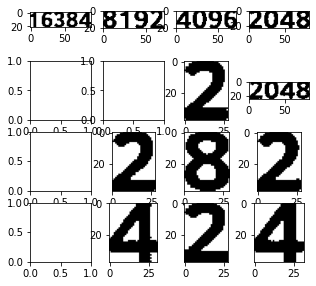

[[16384  8192  4096  2048]
 [    0     0     2  2048]
 [    0     2     8     2]
 [    0     4     2     4]]


In [68]:

plt.rcParams['figure.figsize'] = [5, 5]
fig, axs = plt.subplots(nrows=4, ncols=4)


numbers = np.zeros((4,4), dtype="int")

# 3Ua8x.png
# tiles_origin = (35, 12) # (y, x)
# tiles_spacing = (8, 8) # (y, x)
# tiles_size = (150, 150) # (height, width)
# tiles_crop = 4 # pixels

# 2048-4.jpg
tiles_origin = (7, 11) # (y, x)
tiles_spacing = (14, 14) # (y, x)
tiles_size = (111, 111) # (height, width)
tiles_crop = 8 # pixels

# 2048-4.png
# tiles_origin = (10, 11) # (y, x)
# tiles_spacing = (15, 15) # (y, x)
# tiles_size = (106, 106) # (height, width)
# tiles_crop = 4 # pixels

for i in range(4):
    
    y1 = tiles_origin[0] + (tiles_size[0] + tiles_spacing[0])*i
    y2 = y1 + tiles_size[0]
    y1 += tiles_crop
    y2 -= tiles_crop
    
    for j in range(4):
        
        x1 = tiles_origin[1] + (tiles_size[1] + tiles_spacing[1])*j
        x2 = x1 + tiles_size[1]
        x1 += tiles_crop
        x2 -= tiles_crop
        
        crop = img[y1:y2, x1:x2]
        
        stddev = np.std(crop)
        if(stddev < 0.01):
            continue
        
        # threshold image (black number on white background)
        thresh = skimage.filters.threshold_otsu(crop)
        crop = ((crop > thresh)*255).astype("uint8")
        
        if(np.mean(crop) < 128):
            crop = 255 - crop
        elif(np.mean(crop) > 250):
            crop = np.ones_like(crop)*255
          
        # crop white space
        yc, xc = np.nonzero(crop==0)
        crop = crop[np.min(yc):np.max(yc)+1, np.min(xc):np.max(xc)+1]
            
        # find most similar number
        similarity = np.zeros(16, dtype="float64")
        for i_number in range(1, 16):
            # check if aspect ratios are roughly similar
            a1 = numbers_aspects[i_number]
            a2 = crop.shape[0]/crop.shape[1]
            err = np.abs(1-a1/a2)
            if(err > 0.25):
                similarity[i_number] = 0.0
                continue
            # check if image content is similar
            number = numbers_map[i_number]            
            resized = skimage.transform.resize(crop, number.shape)
            similarity[i_number] = np.count_nonzero(np.logical_and(resized==0, number==0))
            
        exp = np.argmax(similarity)
        if(exp > 0):
            numbers[i][j] = 2**exp
            
        axs[i,j].imshow(crop, cmap="gray", vmin=0, vmax=255)
        
        
plt.show()

print(numbers)

In [288]:
from __future__ import print_function
import ctypes
import time
import os
import math

MULTITHREAD = True

for suffix in ['so', 'dll', 'dylib']:
    dllfn = 'bin/2048.' + suffix
    if not os.path.isfile(dllfn):
        continue
    print(dllfn)
    ailib = ctypes.CDLL(dllfn)
    break
else:
    print("Couldn't find 2048 library bin/2048.{so,dll,dylib}! Make sure to build it first.")
    exit()

ailib.init_tables()
ailib.find_best_move.argtypes = [ctypes.c_uint64]
ailib.score_toplevel_move.argtypes = [ctypes.c_uint64, ctypes.c_int]
ailib.score_toplevel_move.restype = ctypes.c_float

def to_c_board(m):
    board = 0
    i = 0
    for row in m:
        for c in row:
            board |= int(c) << (4*i)
            i += 1
    return board

def print_board(m):
    for row in m:
        for c in row:
            print('%8d' % c, end=' ')
        print()

def _to_val(c):
    if c == 0: return 0
    return 2**c

def to_val(m):
    return [[_to_val(c) for c in row] for row in m]

def _to_score(c):
    if c <= 1:
        return 0
    return (c-1) * (2**c)

def to_score(m):
    return [[_to_score(c) for c in row] for row in m]
        
if MULTITHREAD:
    from multiprocessing.pool import ThreadPool
    pool = ThreadPool(4)
    def score_toplevel_move(args):
        return ailib.score_toplevel_move(*args)

    def find_best_move(m):
        board = to_c_board(m)

        print_board(to_val(m))

        scores = pool.map(score_toplevel_move, [(board, move) for move in range(4)])
        bestmove, bestscore = max(enumerate(scores), key=lambda x:x[1])
        if bestscore == 0:
            return -1
        return bestmove
else:
    def find_best_move(m):
        board = to_c_board(m)
        return ailib.find_best_move(board)

board = numbers.tolist()
print(board)
for i in range(4):
    for j in range(4):
        tval = board[i][j]
        if(tval == 0):
            board[i][j] = 0
        else:
            board[i][j] = int(round(math.log(tval, 2)))
print(board)

move = find_best_move(board)
print(move)


bin/2048.dll
[[32768, 4, 16, 8], [0, 2, 32, 0], [0, 0, 2, 0], [2, 0, 0, 0]]
[[15, 2, 4, 3], [0, 1, 5, 0], [0, 0, 1, 0], [1, 0, 0, 0]]
   32768        4       16        8 
       0        2       32        0 
       0        0        2        0 
       2        0        0        0 
3
